In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
import umap
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from joblib import dump, load

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

In [3]:
# data import
data = pd.read_csv('Training_Dataset.csv')
pairs = pd.read_csv("/Users/duanyueyun/Desktop/Capstone/notebooks (final)/Download apk/repackaging_pairs.txt")

In [4]:
print("Distribution of target:")
data['label'].value_counts()/data.shape[0]

Distribution of target:


1    0.816779
0    0.183221
Name: label, dtype: float64

In [5]:
# Delete useless features told by Shirish
data.drop(['Package_Name', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign',
       'sdkVersion', 'targetSdkVersion'], axis = 1, inplace = True)
# Drop features with 0 variance
data.drop(data.columns[data.nunique()==1].to_list(), axis = 1, inplace = True)

In [7]:
# drop duplicate rows
data = data[~data.duplicated(keep='first')]
y = data['label']

In [8]:
data.shape

(10951, 354)

# Training SVM Model

## Splitting Training and Test set

In [9]:
X=data.drop(columns=['label','SHA256'])
# Create dataset without sensor features in order to see if there's some improvement by adding sensor features
X_wo_sensors = X.drop(X.iloc[:, -29:].columns, axis = 1)
print(X.shape)
print(X_wo_sensors.shape)

(10951, 352)
(10951, 323)


In [84]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y)

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = \
train_test_split(X_wo_sensors, y, test_size = 0.2, random_state = 42, stratify = y)

# Training SVM Model

In [11]:
model = SVC(class_weight='balanced')

In [12]:
avg_val_score = np.mean(cross_val_score(model, X_train, y_train, cv = 5,
                                       scoring = "balanced_accuracy"))
print('The mean test score of Logistic Regression model with sensor features is:', avg_val_score)

The mean test score of Logistic Regression model with sensor features is: 0.8577054376741261


In [13]:
avg_val_score = np.mean(cross_val_score(model, X_train_wo_sensor, y_train_wo_sensor, cv = 5,
                                       scoring = "balanced_accuracy"))
print('The mean test score of Logistic Regression model without sensor features is:', avg_val_score)

The mean test score of Logistic Regression model without sensor features is: 0.8561517848927043


## Tuning Hyperparameters

**1. Training on Dataset Including Sensor Features**

In [14]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SVC(class_weight='balanced'))

params = {'svc__kernel': ['poly', 'rbf'],
          'svc__C': [0.2, 0.5, 1, 10, 100]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params,
                               scoring = "balanced_accuracy")
grid_with_sensor.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.2, 0.5, 1, 10, 100],
                         'svc__kernel': ['poly', 'rbf']},
             scoring='balanced_accuracy')

In [15]:
result_with_sensor = pd.DataFrame(grid_with_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of SVM with Different C (Including Sensor Features)')

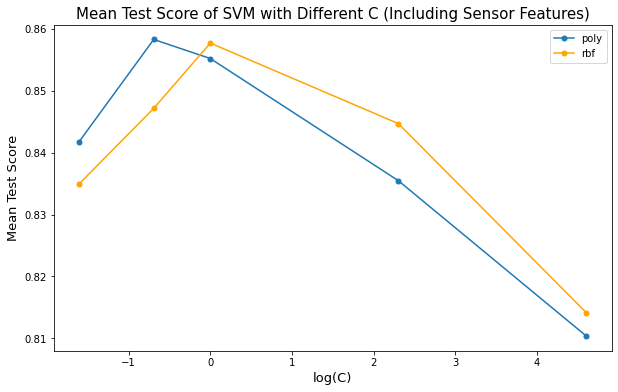

In [16]:
poly_scores = result_with_sensor[result_with_sensor['param_svc__kernel']=='poly']['mean_test_score']
rbf_scores = result_with_sensor[result_with_sensor['param_svc__kernel']=='rbf']['mean_test_score']
plt.figure(figsize = (10, 6))
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), poly_scores, marker = 'o', markersize = 5,
        label='poly')
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), rbf_scores, marker = 'o', markersize = 5, c='orange',
        label='rbf')
plt.legend()
plt.xlabel('log(C)', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of SVM with Different C (Including Sensor Features)', fontsize = 15)

**2. Training on Dataset Not Including Sensor Features**

In [18]:
pipe_wo_sensor = make_pipeline(SVC(class_weight='balanced'))

params = {'svc__kernel': ['poly', 'rbf'],
          'svc__C': [0.2, 0.5, 1, 10, 100]}

grid_wo_sensor = GridSearchCV(pipe_wo_sensor, param_grid = params)
grid_wo_sensor.fit(X_train_wo_sensor, y_train_wo_sensor)

GridSearchCV(estimator=Pipeline(steps=[('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.2, 0.5, 1, 10, 100],
                         'svc__kernel': ['poly', 'rbf']})

In [19]:
result_wo_sensor = pd.DataFrame(grid_wo_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of SVM with Different C (Without Sensor Features)')

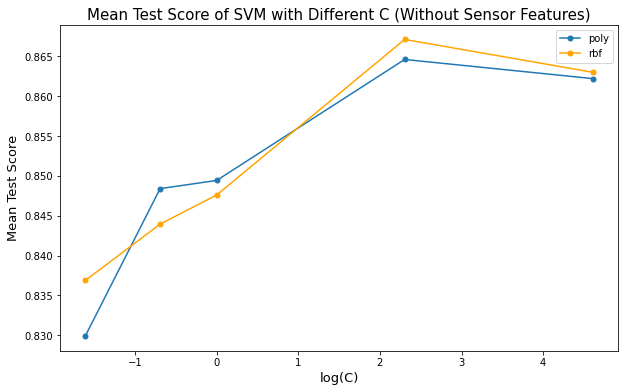

In [20]:
poly_scores2 = result_wo_sensor[result_wo_sensor['param_svc__kernel']=='poly']['mean_test_score']
rbf_scores2 = result_wo_sensor[result_wo_sensor['param_svc__kernel']=='rbf']['mean_test_score']
plt.figure(figsize = (10, 6))
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), poly_scores2, marker = 'o', markersize = 5,
        label='poly')
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), rbf_scores2, marker = 'o', markersize = 5, c='orange',
        label='rbf')
plt.legend()
plt.xlabel('log(C)', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of SVM with Different C (Without Sensor Features)', fontsize = 15)

In [22]:
# export models
dump(grid_with_sensor, 'grid_with_sensor.joblib') 
dump(grid_wo_sensor, 'grid_wo_sensor.joblib') 

['grid_wo_sensor.joblib']

In [ ]:
grid_with_sensor = load('grid_with_sensor.joblib') 
grid_wo_sensor = load('grid_wo_sensor.joblib') 

## Evaluation on Test Data

Adding sensor features improves balanced accuracy slightly.

In [85]:
# make prediction
y_pred_with_sensor = grid_with_sensor.predict(X_test)
y_pred_wo_sensor = grid_wo_sensor.predict(X_test_wo_sensor)

### Balanced accuracy

In [86]:
print("Test score with sensors:",  round(balanced_accuracy_score(y_test, y_pred_with_sensor),3))
print("Test score without sensors:", round(balanced_accuracy_score(y_test_wo_sensor, y_pred_wo_sensor),3))

Test score with sensors: 0.854
Test score without sensors: 0.84


### AUC, precision and recall

In [81]:
#round(roc_auc_score(y_test, y_pred_with_sensor),3)

In [82]:
#round(roc_auc_score(y_test, y_pred_wo_sensor),3)

In [89]:
print("Precision with sensors:")
print(np.round(precision_score(y_test, y_pred_with_sensor, average=None),3))
print("Precision without sensors:")
print(np.round(precision_score(y_test, y_pred_wo_sensor, average=None),3))
print("Recall with sensors:")
print(np.round(recall_score(y_test, y_pred_with_sensor, average=None),3))
print("Recall without sensors:")
print(np.round(recall_score(y_test, y_pred_wo_sensor, average=None),3))

Precision with sensors:
[0.551 0.965]
Precision without sensors:
[0.593 0.952]
Recall with sensors:
[0.865 0.842]
Recall without sensors:
[0.803 0.877]


### ThumbPrint score

In [39]:
data = pd.read_csv('Training_Dataset.csv')
data.drop_duplicates(inplace=True)
data.shape

(10951, 873)

In [40]:
X_test = X_test.merge(data[['label','SHA256', 'ThumbPrint']], left_index=True, right_index=True)
X_test['y_pred_with_sensor'] = y_pred_with_sensor
X_test['y_pred_wo_sensor'] = y_pred_wo_sensor

In [41]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_with_sensor']
summ = X_test[X_test['label']==0].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ

,N,correct,score
ThumbPrint,,,
672C7E09D7971FEFF924CB9BB9DF501B068699D2,26,19.0,0.730769
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,23,15.0,0.652174
F0CA270347F8E2D6D21F4F249BB6FA82AB6F83E3,11,6.0,0.545455
EF6437B4BA486551FBCC4FCB2FB126BB4B911BAB,4,1.0,0.250000
12B91A5CD3D72CC321BD51931937D318555A182D,3,3.0,1.000000
94C9774BC9DA86A75FADDCCF026714CA11352DA5,3,3.0,1.000000
030261EE682280189ADE9A056051855C5537480B,2,2.0,1.000000
958EF8E3A0DA342408E3E088B0476D4FB2AD20F1,2,2.0,1.000000
89B7E5B47DB065541B4B743EDCD5A78FD5E57B0D,2,1.0,0.500000


In [43]:
# scores of top 10 authors
X_test['correct2'] = X_test['label'] == X_test['y_pred_wo_sensor']
summ = X_test[X_test['label']==0].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct2=('correct2','sum'))\
.sort_values(['N','correct2'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct2']/summ['N']
summ

,N,correct2,score
ThumbPrint,,,
672C7E09D7971FEFF924CB9BB9DF501B068699D2,26,18.0,0.692308
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,23,11.0,0.478261
F0CA270347F8E2D6D21F4F249BB6FA82AB6F83E3,11,7.0,0.636364
EF6437B4BA486551FBCC4FCB2FB126BB4B911BAB,4,1.0,0.250000
12B91A5CD3D72CC321BD51931937D318555A182D,3,3.0,1.000000
94C9774BC9DA86A75FADDCCF026714CA11352DA5,3,3.0,1.000000
030261EE682280189ADE9A056051855C5537480B,2,2.0,1.000000
958EF8E3A0DA342408E3E088B0476D4FB2AD20F1,2,2.0,1.000000
89B7E5B47DB065541B4B743EDCD5A78FD5E57B0D,2,0.0,0.000000


### Paired apps v.s. non-paired apps

In [44]:
# obtain pairs where both the original and repackaged apps are in the benign/malware dataset
sample_pairs = pairs[(pairs['SHA256_ORIGINAL'].isin(data['SHA256']))&
                     (pairs['SHA256_REPACKAGE'].isin(data['SHA256']))]
sample_pairs.shape

(3797, 2)

In [45]:
# apps whose original/repackaged counterpart is in the data
s1 = X_test[(X_test['SHA256'].isin(sample_pairs['SHA256_ORIGINAL']))|
           (X_test['SHA256'].isin(sample_pairs['SHA256_REPACKAGE']))]
s1.shape

(916, 359)

In [46]:
# apps whose original/repackaged counterpart is not in the data:
s2 = X_test[(~X_test['SHA256'].isin(sample_pairs['SHA256_ORIGINAL']))&
           (~X_test['SHA256'].isin(sample_pairs['SHA256_REPACKAGE']))]
s2.shape

(1275, 359)

In [47]:
print("Including sensor features:")
print("Overall accuracy:", X_test['correct'].mean())
print("Accuracy for apps whose original/repackaged counterpart is in the data:",
     s1['correct'].mean())
print("Accuracy for apps whose original/repackaged counterpart is not in the data:",
     s2['correct'].mean())

Including sensor features:
Overall accuracy: 0.8461889548151529
Accuracy for apps whose original/repackaged counterpart is in the data: 0.7085152838427947
Accuracy for apps whose original/repackaged counterpart is not in the data: 0.9450980392156862


In [48]:
print("Excluding sensor features:")
print("Overall accuracy:", X_test['correct2'].mean())
print("Accuracy for apps whose original/repackaged counterpart is in the data:",
     s1['correct2'].mean())
print("Accuracy for apps whose original/repackaged counterpart is not in the data:",
     s2['correct2'].mean())

Excluding sensor features:
Overall accuracy: 0.863076220903697
Accuracy for apps whose original/repackaged counterpart is in the data: 0.7358078602620087
Accuracy for apps whose original/repackaged counterpart is not in the data: 0.9545098039215686


#### Test on repackaged benign dataset

In [58]:
benign_repack = pd.read_csv("Test_Dataset.csv")
benign_repack_y = pd.read_csv("Labels_Test.csv")

In [64]:
features = X_train.columns.to_list()
benign_repack = benign_repack[features]

features2 = X_train_wo_sensor.columns.to_list()
benign_repack2 = benign_repack[features2]

In [66]:
# make prediction
y_pred_with_sensor = grid_with_sensor.predict(benign_repack)
y_pred_wo_sensor = grid_wo_sensor.predict(benign_repack2)

In [67]:
print("Test score with sensors:",  round(balanced_accuracy_score(benign_repack_y, y_pred_with_sensor),3))
print("Test score without sensors:", round(balanced_accuracy_score(benign_repack_y, y_pred_wo_sensor),3))

Test score with sensors: 0.971
Test score without sensors: 0.967


/Users/duanyueyun/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


#### Test on covid repackaged malware dataset

In [69]:
covid = pd.read_csv("DataSet_COVID_Repackaged_Malware.csv")
covid.shape

(14, 843)

In [73]:
covid_test = covid[features2]

In [75]:
y_pred_wo_sensor = grid_wo_sensor.predict(covid_test)

In [77]:
covid_label = np.array([1]*14)

In [80]:
print("Number of malware in the dataset:", covid.shape[0])
print("Number of malware identified:", sum(y_pred_wo_sensor))

Number of malware in the dataset: 14
Number of malware identified: 3
